<a href="https://colab.research.google.com/github/arjitkatare/Noise_GAN/blob/master/Rephrase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**File Download Script**


In [0]:
######Install files by uncommneting these######

# !wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip # uncomment it and run this if folder is not located in home directory
# !unzip -q pub*

In [0]:
######## if more than one duplicate exist than use this to delete them#######
  
# !rm -r pub*   

# **Imports**

In [0]:
#%matplotlib inline
import sys
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

from torchvision import transforms, datasets
import torchvision.utils as vutils

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


import cv2
import numpy as np

# **Mount Your Drive**

In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)





# *Trick*

In [0]:
###Trick##
#Allocate memory to a tensor and delete it just before your training starts
memory_holder = torch.zeros(200000,10000, device = 'cuda:0') #Loop hole for allocating gpu to us after restarting runtime faster :P

# Continue

## **Checking Free Memory**

In [5]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 11.5 GB  | Proc size: 1.9 GB
GPU RAM Free: 3475MB | Used: 7966MB | Util  70% | Total 11441MB


## **Reset and Evaluation Control**

In [0]:
reset = False # Make sure this is False after you start training else your checkpoint is dead
Evaluation = False

## **Given degrade function**

In [0]:
# We will just use some part of it during implementing transforms while making dataloader function

import cv2
import numpy as np

def degrade(input_path: str, output_path: str) -> None:
        """Load image at `input_path`, distort and save as `output_path`"""
        SHIFT = 2
        image = cv2.imread(input_path)
        to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
        swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
        swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
        image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
        image[swap_indices] = swap_vals
        cv2.imwrite(output_path, image)
        

# **Main Code**

## **Setting Seed**

In [8]:
#Setting seed for reproducibility
random.seed(2)
torch.manual_seed(2)

## **Constants and Hyperparemeters**

In [0]:
ngpu = 1
batch_size = 64
i_size = 64
n_ch = 3
num_epochs = 10
n_iters = 100
n_fg = 32
n_fd = 32
lr = 0.0001
beta1 = 0.5



## New function using degrade logic

In [0]:
def distortion(image):
  SHIFT = 2
  to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
  swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
  swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
  image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
  image[swap_indices] = swap_vals
  return image

## Data processing

In [0]:


def dataloader_loader(which_dataset, distort = False):
  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(i_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5, 0.5, 0.5], #Normalizing as the values are in range [0,1] in given dataset
                               std=[0.25, 0.25, 0.25]), # some empirical changes for visiual quality check
      ])
  if distort:
    data_transform = transforms.Compose([data_transform, transforms.Lambda(lambda img: distortion(img))])
  root_dir = '/content/pubfig83lfw_raw_in_dirs/{}'.format(which_dataset)
  rephrase_dataset = datasets.ImageFolder(root=root_dir,
                                             transform=data_transform)
  return torch.utils.data.DataLoader(rephrase_dataset,
                                    batch_size= batch_size, shuffle=True,
                                    num_workers=1)

In [12]:
# Counting number of files we have in our directory

import os
rootdir = '/content/pubfig83lfw_raw_in_dirs/train'

train_count = 0
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
#         print os.path.join(subdir, file)
      train_count+=1
print(train_count)

8720


In [13]:
train_dataloader_real = dataloader_loader('train')
train_dataloader_fake = dataloader_loader('train', True)
len(dataloader_loader('train'))

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:692: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


137

Length is less due to batching, dataloader stores number of files they have in total by default and after batching we get total number of possible batches

## Setting device to use for tensor operation

In [14]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = 'cpu' #gpu is full so using cpu as default
print('Using - ',device)

Using -  cuda:0


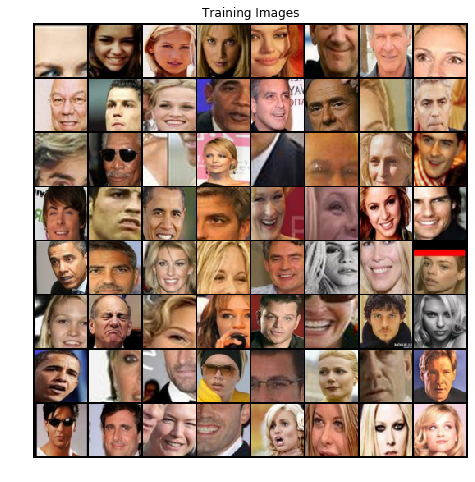

In [15]:
# Plot some training images
real_batch = next(iter(train_dataloader_real))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


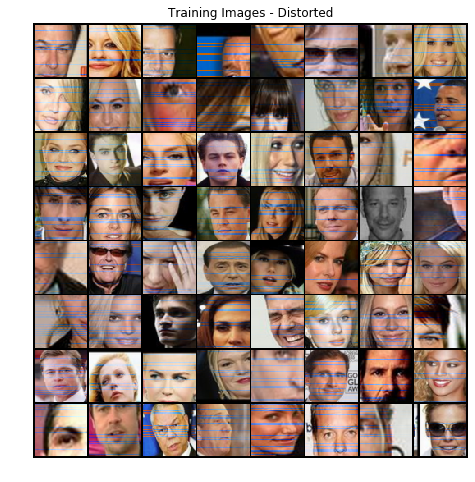

In [16]:
# Plot some training images
fake_batch = next(iter(train_dataloader_fake))
len(fake_batch[0])
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images - Distorted")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


## Weight Init function for batchnorm and conv2d

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [0]:
# Generator Code

class Generator_v1(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg)
        self.conv2 = conv_relu_normalized(n_fg,n_fg*4)
        self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
        self.conv4 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
        self.conv6 = conv_relu_normalized(n_fg*4,n_fg)
        self.conv7 = conv_relu_normalized(n_fg,n_ch)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x

class Generator_v2(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg)
        self.conv2 = conv_relu_normalized(n_fg,n_fg*8)
#         self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
        self.conv4_1 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_2 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_3 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_4 = conv_relu_normalized(n_fg*8,n_fg*8)
#         self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
        self.conv6 = conv_relu_normalized(n_fg*8,n_fg)
        self.conv7 = nn.Conv2d(n_fg,n_ch,3, padding = 2, dilation = 2 )
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
#         x = self.conv3(x)
        
        x = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv4_2(x) + x
        x = self.conv4_3(x) + x
        x = self.conv4_4(x) + x
        
#         x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x

class Generator_v3(nn.Module): # DenseNet architecture for better flow of gradients back to the layers during backward() call
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        
        def conv_relu_normalized(inp,out):
          return nn.Sequential(nn.Conv2d(inp,out,3, padding = 2, dilation = 2 ), # fixing value such that size remain same. Damn Tf is smarter in handling this
          nn.LeakyReLU(True),
          nn.BatchNorm2d(out)
          )
          
        self.conv1 = conv_relu_normalized(n_ch,n_fg*8)
#         self.conv2 = conv_relu_normalized(n_fg,n_fg*8)
#         self.conv3 = conv_relu_normalized(n_fg*4,n_fg*8)
        self.conv4_1 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_2 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_3 = conv_relu_normalized(n_fg*8,n_fg*8)
        self.conv4_4 = conv_relu_normalized(n_fg*8,n_fg*8)
#         self.conv5 = conv_relu_normalized(n_fg*8,n_fg*4)
#         self.conv6 = conv_relu_normalized(n_fg*8,n_fg)
        self.conv7 = conv_relu_normalized(n_fg*8,n_ch)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        
        x = self.conv1(x)
#         x = self.conv3(x)
        
        x = self.conv4_1(x) #DenseNet for better gradient flow back to the generator
        x = self.conv4_2(x) + x
        x = self.conv4_3(x) + x
        x = self.conv4_4(x) + x
        
#         x = self.conv5(x)
        x = self.conv7(x)
        x = self.tanh(x)
        
        return x
    
    

## Generator Graph

In [19]:
# Create the generator
netG = Generator_v2(ngpu).to(device)
netG.apply(weights_init)


print(netG)

Generator_v2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

## Output size assertion of generator

In [0]:
fake_value = next(iter(train_dataloader_fake))
assert fake_value[0][0:1].to(device).shape == netG(fake_value[0][0:1].to(device)).shape

In [21]:

len(fake_value[0][0:1]),netG(fake_value[0][0:1].to(device)).shape


(1, torch.Size([1, 3, 64, 64]))

## Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(n_ch, n_fd , 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd),  # I missed this somehow,  uncomment it after resetting runtime
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),

            nn.Conv2d(n_fd, n_fd * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),

            nn.Conv2d(n_fd * 2, n_fd * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),

            nn.Conv2d(n_fd * 4, n_fd * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_fd * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),

            nn.Conv2d(n_fd * 8, 1, 4, 1, 0, bias=False),
            
        )
        self.fc1 = nn.Linear(1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x_len = x.size(1) 
        
#         x = self.fc1(x)
#         print(1)
        
        x = self.sigmoid(x)
        return x
        

In [23]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Dropout(p=0.4)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace)
    (7): Dropout(p=0.4)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Dropout(p=0.4)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=

## Output test for discriminator

In [24]:
real_value = next(iter(train_dataloader_real))
type(real_value)

list

In [25]:
print(len(netD(real_value[0][0:5].to(device)).view(-1)))
netD(real_value[0][0:1].to(device)).view(-1)

5


tensor([0.5831], device='cuda:0', grad_fn=<ViewBackward>)

## Setting up loss function and optimiser

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Checking D

In [0]:

checkpoint_path = 'drive/My Drive/rephrase_weights'

if len(os.listdir(checkpoint_path) ) == 0:
    checkpoint_load = False
else:    
    checkpoint_load = True


checkpoint_path = checkpoint_path + '/v1.pt'


## Pre-Training tasks


In [0]:


if reset == True:
  checkpoint_load = False
  print(' reset is True and checkpoints will be reinitialised')
else:
  checkpoint_load = True

## Training

In [0]:
# Training Loop

##### Play wit these accordingly to check how your GAN is mapping out the noise pattern ########
#Some training constants to keep check from a single place
GENERATOR_FORCING = 1 #how many extra time you want to train your Generator
turn_off_discriminator_training = False

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
start_epoch = 0

del(memory_holder)

if checkpoint_load == True:
  print('Checkpoint found')
  state = torch.load(checkpoint_path)
  netG.load_state_dict(state['generator_state'])
  netD.load_state_dict(state['discriminator_state'])
  iters = state['iters']
  img_list = state['img_list']
  G_losses = state['G_losses']
  D_losses = state['D_losses']
  start_epoch = state['epoch']
  print('Checkpoint loaded')
  print('Epochs - ', start_epoch)
  print('iters - ', iters)
else:
  netG.apply(weights_init)
  netD.apply(weights_init)
  

#Here we have assumed that real and fake are analogous to normal and distorted images

######## Important part #######
#Setting both in train mode initially
netG.train()
netD.train()

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch,num_epochs):
  if Evaluation == True:
    break
    
  fixed_noise = next(iter(train_dataloader_fake))
  #     fixed_data_for_validation =  
  # For each batch in the dataloader
  for i, data in enumerate(train_dataloader_real, 0):

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################

#       netG.eval()
#       netD.train()

      ## Train with all-real batch
      netD.zero_grad()

      # Format batch
      real_data = data[0].to(device)
      b_size = real_data.size(0)
      label = torch.full((b_size,), real_label, device=device)

      # Forward pass real batch through D
      output = netD(real_data).view(-1)


      # Calculate loss on all-real batch
      errD_real = criterion(output, label)

      # Calculate gradients for D in backward pass
      errD_real.backward()
      D_x = output.mean().item()

      ## Train with all-fake batch
      # Generate batch of latent vectors

      noise = next(iter(train_dataloader_fake))

      # Generate fake image batch with G
      fake = netG(noise[0].to(device))

      label.fill_(fake_label) # resuing the same label again. just to save memory

      # Classify all fake batch with D
      output = netD(fake.detach()).view(-1)

      # Calculate D's loss on the all-fake batch
      try:
        errD_fake = criterion(output, label)
      except:
        continue

      # Calculate the gradients for this batch
      errD_fake.backward()
      D_G_z1 = output.mean().item()

      # Add the gradients from the all-real and all-fake batches
      errD = errD_real + errD_fake

      # Update D
      if not turn_off_discriminator_training:
        optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################

#       netG.train()
#       netD.eval()

      generator_forcing = GENERATOR_FORCING
      label.fill_(real_label)  # fake labels are real for generator cost

      for _ in range(generator_forcing):
        netG.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward(retain_graph = True)
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()

      # Output training stats
      if i % 50 == 0:
          print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(train_dataloader_real),
                   errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          state = {
              'discriminator_state': netD.state_dict(),
              'generator_state': netG.state_dict(),
              'iters': iters,
              'epoch': epoch,
              'img_list':img_list,
              'G_losses': G_losses,
              'D_losses': D_losses
          }
          torch.save(state,checkpoint_path)
          print('models saved for both netG and netD in state with variables\n\n')

      # Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())

      # Check how the generator is doing by saving G's output on fixed_noise
      if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader_real)-1)):
          with torch.no_grad():
              fake = netG(fixed_noise[0].to(device)).detach().cpu()
          img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1
      
      if i == 136:
        break

Checkpoint found
Checkpoint loaded
Epochs -  0
iters -  1000
Starting Training Loop...
[0/10][0/137]	Loss_D: 0.6066	Loss_G: 3.5031	D(x): 0.9608	D(G(z)): 0.2983 / 0.0693
models saved for both netG and netD in state with variables


[0/10][50/137]	Loss_D: 0.0165	Loss_G: 6.5811	D(x): 0.9929	D(G(z)): 0.0087 / 0.0070
models saved for both netG and netD in state with variables




## Setting model for evaluation

In [0]:
netG.eval()
netD.eval()

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
with torch.no_grad():
  fake_cleared = netG(fixed_noise[0].to(device)).detach().cpu()



In [0]:
with torch.no_grad():
  fake = (fixed_noise[0].to(device)).detach().cpu()



In [0]:
# Plot some training images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Distorted")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# Plot some training images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Processed")
plt.imshow(np.transpose(vutils.make_grid(fake_cleared.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# #%%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

In [0]:
# # Grab a batch of real images from the dataloader
# real_batch = next(iter(train_dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# # Plot the fake images from the last epoch
# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
# plt.show()